This notebook is a part of the competition 'Predict H1N1 and Seasonal Flu Vaccines' from the website Driven Data

Importing necessary libraries

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6  

1-Loading our data

The first thing that we need to do is to load our data

In [3]:
trainf = pd.read_csv(
    r'C:\Users\danie\OneDrive\Desktop\Daniel\Data Science\Competitions\Driven data\training_set_features.csv',
    index_col = 'respondent_id')
trainl = pd.read_csv(
    r'C:\Users\danie\OneDrive\Desktop\Daniel\Data Science\Competitions\Driven data\training_set_labels.csv',
    index_col = 'respondent_id')

Quick look at the data

In [4]:
trainf.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
trainl.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


Checking the dtypes of the training features

In [6]:
trainf.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

Here we are going to check if the rows between the features and labels match up. We are going to use one tool from numpy (assert_array_equal) that gives an error if they don't match

In [7]:
np.testing.assert_array_equal(trainf.index.values, trainl.index.values)

As we didn't receive any error, we conclude that everything is fine

2-Exploratory analysis

Now we are going to explore the data through visualizations using seaborn

We start by analyzing the labels, that means that we are going to check how many people took the vaccines for each disease

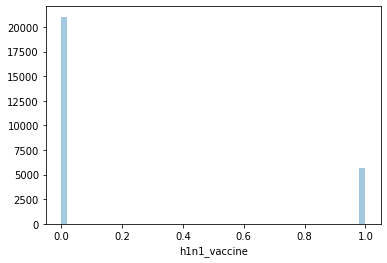

In [8]:
sns.distplot(a=trainl['h1n1_vaccine'], kde=False)

So, by looking into this data we can check that most people didn't took the vaccines for h1n1

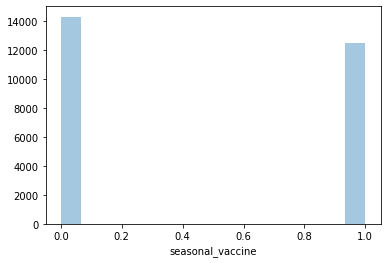

In [9]:
sns.distplot(a=trainl['seasonal_vaccine'], kde=False)

In this case the things are more balanced but there are more negative cases than positive ones yet

Are the two target variables independent?

In [12]:
pd.crosstab(
    trainl['h1n1_vaccine'],
    trainl['seasonal_vaccine'],
    margins=True,
    normalize=True)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [13]:
(trainl['h1n1_vaccine']
    .corr(trainl['seasonal_vaccine'], method='pearson')
)

0.37714265306144557

So we can check that this two variables have a correlation of 37%.

3-Feature engineering

As we saw above, the datasets contain a mix of categorical and numerical variables.

Let's combine the features and labels into just one dataframe

In [15]:
#joining the two dataframes
train = trainf.join(trainl)
#checking the shape
print(train.shape)
#a quick look
train.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Now we want to check the correlations between the 'h1n1_concern' and the 'h1n1_vaccine'. This way we can see how much the fact people are concerned about something affects their decision to take the vaccine

In [16]:
#counts of observations for each combination of those two variables
counts = (train[['h1n1_concern', 'h1n1_vaccine']]
             .groupby(['h1n1_concern', 'h1n1_vaccine'])
             .size()
             .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


Let's put this in a bar chart to check easily the connections that exist

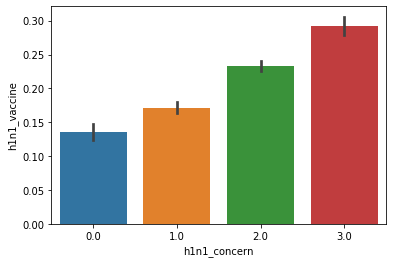

In [17]:
sns.barplot(x=train['h1n1_concern'], y=train['h1n1_vaccine'])

We can check that the higher the concern, the higher usage of vaccines, even though that just nearly 30% of the higher concern people took the vaccines, which mean that most people keep not taking it.

4-Building some models

In [21]:
trainf.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [22]:
trainf.dtypes != 'object'

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
r

As we can see we have a lot of categorical variables and missing values. So, now we need to preprocess them before building the model

4.1-Feature preprocessing

In [29]:
numeric_cols = trainf.columns[trainf.dtypes != 'object'].values

In [30]:
numeric_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

In [31]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing, numeric_cols)
    ],
    remainder = "drop"
)

Estimator

In [32]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

Full pipeline

In [33]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators),
])

Training our model

In [34]:
#splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(
    trainf,
    trainl,
    test_size=0.33,
    shuffle=True,
    stratify=trainl,
    random_state=RANDOM_SEED
)

In [35]:
#train the model
full_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standard_scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                 

In [38]:
#predict on evaluation set
preds = full_pipeline.predict_proba(X_valid)
preds

[array([[0.70898963, 0.29101037],
        [0.9022304 , 0.0977696 ],
        [0.84459811, 0.15540189],
        ...,
        [0.92338263, 0.07661737],
        [0.89632521, 0.10367479],
        [0.92787943, 0.07212057]]),
 array([[0.52721977, 0.47278023],
        [0.61838467, 0.38161533],
        [0.37024394, 0.62975606],
        ...,
        [0.85936904, 0.14063096],
        [0.77843342, 0.22156658],
        [0.15115096, 0.84884904]])]

In [37]:
print(preds[0].shape)
print(preds[1].shape)

(8814, 2)
(8814, 2)


We received two arrays. The first array is related to the h1n1_vaccine, while the second is for the seasonal_vaccine

In [40]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_valid.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291010,0.472780
16516,0.097770,0.381615
3106,0.155402,0.629756
16981,0.661791,0.857876
19111,0.284478,0.776927


Now let's train again our model using the full dataset

In [46]:
full_pipeline.fit(trainf, trainl)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standard_scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                 

5-Generating predictions for the test

In [48]:
test = pd.read_csv(
    r'C:\Users\danie\OneDrive\Desktop\Daniel\Data Science\Competitions\Driven data\test_set_features.csv',
    index_col = 'respondent_id')

Now we are going to make predictions in the test set. In this competition we want probabilities, not binary label predictions (0 or 1). So we are going to use '.predict_proba' method 

In [49]:
test_prob = full_pipeline.predict_proba(test)
test_prob

[array([[0.87280333, 0.12719667],
        [0.94475602, 0.05524398],
        [0.62906951, 0.37093049],
        ...,
        [0.80411015, 0.19588985],
        [0.9492446 , 0.0507554 ],
        [0.38421362, 0.61578638]]),
 array([[0.57359831, 0.42640169],
        [0.92876678, 0.07123322],
        [0.3626162 , 0.6373838 ],
        ...,
        [0.59872448, 0.40127552],
        [0.68003071, 0.31996929],
        [0.35787941, 0.64212059]])]

Now we are going to put our results in the submission file, so then we can submit it to the competion!

In [51]:
submission = pd.read_csv(
    r'C:\Users\danie\OneDrive\Desktop\Daniel\Data Science\Competitions\Driven data\submission_format.csv',
    index_col = 'respondent_id')

In [52]:
#let's take a look
submission.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


So now we need to take out those 0.5's and 0.7's and replace them with our probabilities

In [54]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission.index.values)

# Save predictions to submission data frame
submission["h1n1_vaccine"] = test_prob[0][:, 1]
submission["seasonal_vaccine"] = test_prob[1][:, 1]

submission.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.127197,0.426402
26708,0.055244,0.071233
26709,0.370930,0.637384
26710,0.464351,0.803446
26711,0.286673,0.634903


In [61]:
submission.to_csv('my_submission.csv', index=True)